### Facies Prediction - Deep Learning

Here we will get you started using deep learning to associate a suite of well-log measurements, with set of lithofacies. To start with we have a set of facies labels made from an interpreter, we train a model and predict to a blind well. Exact details of the problem can be found in the seminal paper by Hall (2016); https://doi.org/10.1190/tle35100906.1. A with problems with a simple point-wise machine learning solution it exhibits high frequency noise in its prediction. Instead of looking at the data point-wise, we want a machine to look at a scene in a broader context. Borrowing from natural language processing and deep learning we show a baseline implementation using a method call LSTM, looking at the broader scene gives commensurate predictive power, but without the unphysical noise. 

Access this notebook on https://blasscoc.github.io/LinkedInArticles/

Other datasets and solutions to the problem can be found here:
https://agilescientific.com/blog/2016/12/8/seg-machine-learning-contest-theres-still-time

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

import numpy as np

import matplotlib.pylab as plt

from sklearn.metrics import classification_report

# Convenience method from the seminal work of https://github.com/brendonhall
from competition_facies_plots import (make_facies_log_plot, 
                                      compare_facies_plot, 
                                      facies_colors)

from utils import (load_data, chunk, setup_svc, setup_lstm, 
                   train_predict_lstm, train_predict_svc,
                   WELL_NAMES)

#
from filters import morlet_1d, gauss_1d

from scipy.fftpack import ifft, fftshift, convolve

Using TensorFlow backend.


In [2]:
wvars = ['GR', 'DeltaPHI', 'PE', 'PHIND', 'ILD_log10', 'NM_M'];
sca_vars = ['GR', 'DeltaPHI', 'PE', 'PHIND', 'ILD_log10'];


In [3]:
all_wells = load_data()

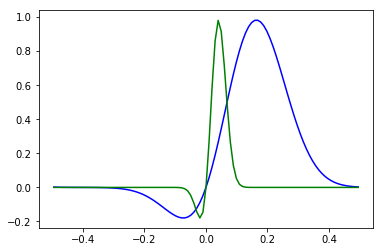

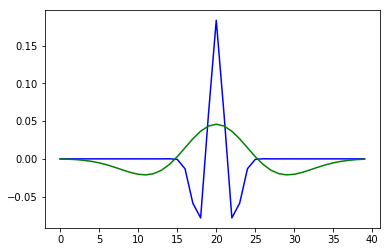

In [4]:
N = 101
plt.figure()
plt.plot(fftshift(np.fft.fftfreq(101)), fftshift(morlet_1d(101, 0.15, 0.1)),'b')
plt.plot(fftshift(np.fft.fftfreq(101)), fftshift(morlet_1d(101, 0.15/4, 0.1/4)),'g')
plt.show()

K=20
plt.figure()
plt.plot(fftshift(ifft(morlet_1d(101, 0.15, 0.1)).real)[N//2-K:N//2+K],'-b')
plt.plot(fftshift(ifft(morlet_1d(101, 0.15/4, 0.1/4)).real)[N//2-K:N//2+K],'-g')
plt.show()




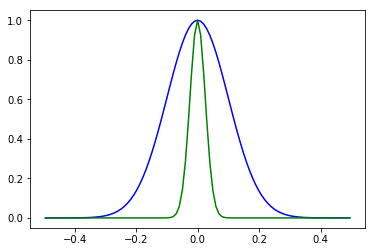

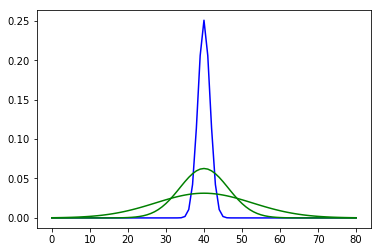

In [5]:
N = 101
plt.figure()
plt.plot(fftshift(np.fft.fftfreq(101)), fftshift(gauss_1d(101,0.1)),'b')
plt.plot(fftshift(np.fft.fftfreq(101)), fftshift(gauss_1d(101,0.1/4)),'g')
plt.show()

K=40
plt.figure()
plt.plot(fftshift(ifft(gauss_1d(101, 0.1)).real)[N//2-K:N//2+K+1],'-b')
plt.plot(fftshift(ifft(gauss_1d(101, 0.1/4)).real)[N//2-K:N//2+K+1],'-g')
plt.plot(fftshift(ifft(gauss_1d(101, 0.1/8)).real)[N//2-K:N//2+K+1],'-g')

plt.show()

In [31]:
from scipy.fftpack import ifft, fftshift, convolve

def morlet_high_freq(N=101):
    _morlet = fftshift(ifft(morlet_1d(N, 0.15, 0.1)))
    re = _morlet.real
    im = _morlet.imag
    crop = 7
    return fftshift(re[N//2-crop:N//2+crop+1]), fftshift(im[N//2-crop:N//2+crop+1])

def morlet_low_freq(N=101):
    _morlet = fftshift(ifft(morlet_1d(N, 0.15/4, 0.1/4)))
    re = _morlet.real
    im = _morlet.imag
    crop = 24
    return fftshift(re[N//2-crop:N//2+crop+1]), fftshift(im[N//2-crop:N//2+crop+1])

def gauss_high_freq(N=101):    
    gauss = fftshift(ifft(gauss_1d(N, 0.1)).real)
    crop = 7
    gauss = gauss[N//2-crop:N//2+crop+1]
    return fftshift(gauss)

def gauss_low_freq(N=101):    
    gauss = fftshift(ifft(gauss_1d(N, 0.1/4)).real)
    crop = 24
    gauss = gauss[N//2-crop:N//2+crop+1]   
    return fftshift(gauss)

def gauss_very_low_freq(N=101):    
    gauss = fftshift(ifft(gauss_1d(N, 0.1/8)).real)
    crop = 33
    gauss = gauss[N//2-crop:N//2+crop+1]   
    return fftshift(gauss)


In [56]:
from scipy import convolve
from pandas import Series

def scattering(series, _morlet, _gauss):
    re, im = _morlet()
    ga = _gauss()

    _re = convolve(series, re, mode='same')
    _im = convolve(series, im, mode='same')

    _sca = np.sqrt(_re*_re + _im*_im)
    _scaler = convolve(np.sqrt(_re*_re + _im*_im), ga, mode='same')
    
    return _sca, _scaler


def scattering_transform(well, series):
    
    additional_keys = [series + "_00", series + "_1", series + "_1", series + "_12"]
        
    _series = well[series].values
    
    
    # ---- #
    _sca2, _scaler2 = scattering(_series, morlet_high_freq, gauss_high_freq)
    well[series + "_2"] = Series(_scaler2, index=well.index)

    # ---- #
    _sca1, _scaler1 = scattering(_series, morlet_low_freq, gauss_low_freq)
    well[series + "_1"] = Series(_scaler1, index=well.index)

    _sca12, _scaler12 = scattering(_sca1, morlet_high_freq, gauss_high_freq)
    well[series + "_12"] = Series(_scaler12, index=well.index)
    
    # ---- #    
    x = convolve(gauss_very_low_freq(), np.pad(_series, (30,), 
                                               mode="edge"), mode="same")
    well[series + "_00"] = x[30:-30]

    
    return well, additional_keys


In [57]:
for key, val in all_wells.items():
    additional_keys = []
    for trac in sca_vars:
        all_wells[key], _keys = scattering_transform(val, trac)
        additional_keys.extend(_keys)

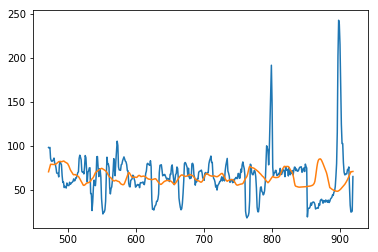

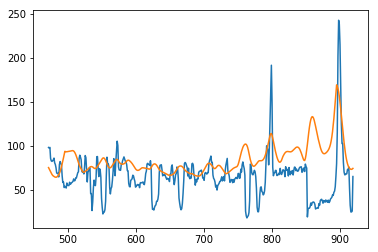

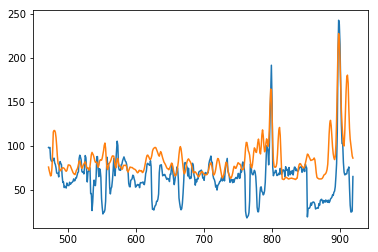

In [58]:
plt.figure()
plt.plot(all_wells['SHANKLE']['GR'])
plt.plot(all_wells['SHANKLE']['GR_00'])
plt.show()

plt.figure()
plt.plot(all_wells['SHANKLE']['GR'])
plt.plot(all_wells['SHANKLE']['GR_1']*3+60)
plt.show()

plt.figure()
plt.plot(all_wells['SHANKLE']['GR'])
plt.plot(all_wells['SHANKLE']['GR_2']*3+60)
plt.show()

In [68]:
print(np.corrcoef(all_wells['SHANKLE']['GR'],all_wells['SHANKLE']['GR_00'])[0,1])
print(np.corrcoef(all_wells['SHANKLE']['GR'],all_wells['SHANKLE']['GR_1'])[0,1])
print(np.corrcoef(all_wells['SHANKLE']['GR'],all_wells['SHANKLE']['GR_2'])[0,1])
print(np.corrcoef(all_wells['SHANKLE']['GR_1'],all_wells['SHANKLE']['GR_2'])[0,1])
print(np.corrcoef(all_wells['SHANKLE']['GR_1'],all_wells['SHANKLE']['GR_12'])[0,1])


-0.236511432564
0.200163879415
0.443129305537
0.440539613725
0.393098010778


In [9]:
_wvars = wvars + additional_keys
train_predict_svc(all_wells,
                  wvars =_wvars);

train_predict_lstm(all_wells,
                  wvars = _wvars,                 
                  win=7,
                  batch_size = 128,
                  dropout=0.1,
                  max_epochs=80,
                  num_hidden=100,
                  num_classes=11);


CHURCHMAN BIBLE
CROSS H CATTLE
LUKE G U
NEWBY
NOLAN
Recruit F9
SHRIMPLIN
SHANKLE


/Users/blasscock/Documents/Hackathon/InstaFamous/LinkedInArticles/ScatNet/utils.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  np.argmax(prediction[:upper], axis=1)+1
/Users/blasscock/Documents/Hackathon/InstaFamous/LinkedInArticles/ScatNet/utils.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  all_wells[blind][label][win//2:-win//2] = prediction[:upper,i]


KeyboardInterrupt: 

In [16]:
prediction_svc = np.hstack(
    [all_wells[well]['PredictionSVC'].values for well in WELL_NAMES])
prediction_lstm = np.hstack(
    [all_wells[well]['PredictionLSTM'].values for well in WELL_NAMES])

facies = np.hstack([
    all_wells[well]['Facies'].values for well in WELL_NAMES])

print ("\n\nHold-one/Predict Cross-Validation performance\n\n")
print(classification_report(prediction_svc, facies))
print(classification_report(prediction_lstm, facies))

print ("\n\nHold-one/Predict SHANKLE-Well example\n\n")
print(classification_report(all_wells['SHANKLE']['PredictionSVC'], 
                            all_wells['SHANKLE']['Facies']))
print(classification_report(all_wells['SHANKLE']['PredictionLSTM'], 
                            all_wells['SHANKLE']['Facies']))




Hold-one/Predict Cross-Validation performance


             precision    recall  f1-score   support

          1       0.08      0.17      0.11       121
          2       0.58      0.48      0.52       892
          3       0.50      0.48      0.49       635
          4       0.40      0.43      0.42       171
          5       0.04      0.06      0.05       150
          6       0.40      0.41      0.40       453
          7       0.15      0.23      0.18        65
          8       0.52      0.45      0.48       570
          9       0.73      0.67      0.70       175

avg / total       0.47      0.44      0.45      3232

             precision    recall  f1-score   support

        1.0       0.26      0.72      0.38        95
        2.0       0.74      0.55      0.63       995
        3.0       0.55      0.63      0.59       534
        4.0       0.39      0.38      0.39       188
        5.0       0.01      0.18      0.02        11
        6.0       0.55      0.43      0.49   

/Users/blasscock/.edm/envs/learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [ ]:
proba_svc = ["PredictionSVC-%d" %i for i in range(11)]
proba_lstm = ["PredictionLSTM-%d" %i for i in range(11)]
svars = ['PredictionSVC', 'PredictionLSTM'] 
train_predict_lstm(all_wells,
                   name="PredictionStacked",
                   wvars = svars,                 
                   win=7,
                   batch_size = 128,
                   dropout=0.0,
                   max_epochs=80,
                   num_hidden=10,
                   num_classes=11);

In [190]:
# This is fast if you have GPU!
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Input, Embedding, 
                          Dropout, Conv1D, MaxPooling1D, 
                          BatchNormalization)
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.initializers import Zeros

lstm_model = make_scattering(len(X_train))
lstm_model.add(LSTM(num_hidden,batch_input_shape=(batch_size, len(X_train)), stateful=True))
lstm_model.add(Dense(num_classes, activation='sigmoid'))
lstm_model.compile(loss='categorical_crossentropy', 
                    optimizer='adam', metrics=['accuracy'])    


NameError: name 'X_train' is not defined

In [3]:
train_predict_svc(all_wells,
                  wvars = ['GR', 'DeltaPHI', 'PE', 'PHIND',
                           'ILD_log10', 'NM_M']);

train_predict_lstm(all_wells,
                  wvars = ['GR', 'DeltaPHI', 'PE', 'PHIND',
                           'ILD_log10', 'NM_M'],                 
                  win=7,
                  batch_size = 128,
                  dropout=0.1,
                  max_epochs=80,
                  num_hidden=100,
                  num_classes=11);



CHURCHMAN BIBLE
CROSS H CATTLE
LUKE G U
NEWBY
NOLAN
Recruit F9
SHRIMPLIN
SHANKLE
CHURCHMAN BIBLE


/Users/blasscock/Documents/Hackathon/InstaFamous/LinkedInArticles/Diversity/utils.py:227: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  np.argmax(prediction[:upper], axis=1)+1
/Users/blasscock/Documents/Hackathon/InstaFamous/LinkedInArticles/Diversity/utils.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  all_wells[blind][label][win//2:-win//2] = prediction[:upper,i]


CROSS H CATTLE
LUKE G U
NEWBY
NOLAN
Recruit F9
SHRIMPLIN
SHANKLE


In [19]:
prediction_svc = np.hstack(
    [all_wells[well]['PredictionSVC'].values for well in WELL_NAMES])
prediction_lstm = np.hstack(
    [all_wells[well]['PredictionLSTM'].values for well in WELL_NAMES])
prediction_stacked = np.hstack(
    [all_wells[well]['PredictionStacked'].values for well in WELL_NAMES])

facies = np.hstack([
    all_wells[well]['Facies'].values for well in WELL_NAMES])

print ("\n\nHold-one/Predict Cross-Validation performance\n\n")
print(classification_report(prediction_svc, facies))
print(classification_report(prediction_lstm, facies))
print(classification_report(prediction_stacked, facies))

print ("\n\nHold-one/Predict SHANKLE-Well example\n\n")
print(classification_report(all_wells['SHANKLE']['PredictionSVC'], 
                            all_wells['SHANKLE']['Facies']))
print(classification_report(all_wells['SHANKLE']['PredictionLSTM'], 
                            all_wells['SHANKLE']['Facies']))
print(classification_report(all_wells['SHANKLE']['PredictionStacked'], 
                            all_wells['SHANKLE']['Facies']))



Hold-one/Predict Cross-Validation performance


             precision    recall  f1-score   support

          1       0.08      0.17      0.11       121
          2       0.58      0.48      0.52       892
          3       0.50      0.48      0.49       635
          4       0.40      0.43      0.42       171
          5       0.04      0.06      0.05       150
          6       0.40      0.41      0.40       453
          7       0.15      0.23      0.18        65
          8       0.52      0.45      0.48       570
          9       0.73      0.67      0.70       175

avg / total       0.47      0.44      0.45      3232

             precision    recall  f1-score   support

        1.0       0.27      0.73      0.39        95
        2.0       0.73      0.54      0.62       987
        3.0       0.55      0.63      0.59       541
        4.0       0.39      0.39      0.39       186
        5.0       0.01      0.18      0.02        11
        6.0       0.55      0.43      0.49   

/Users/blasscock/.edm/envs/learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


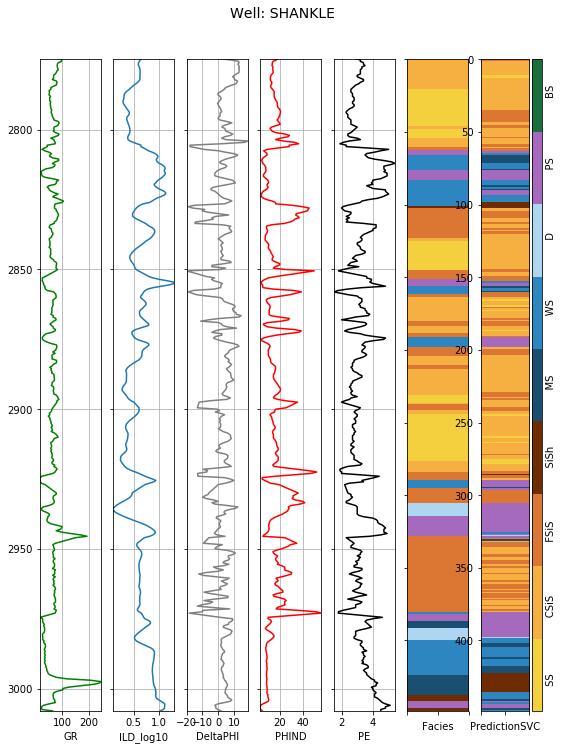

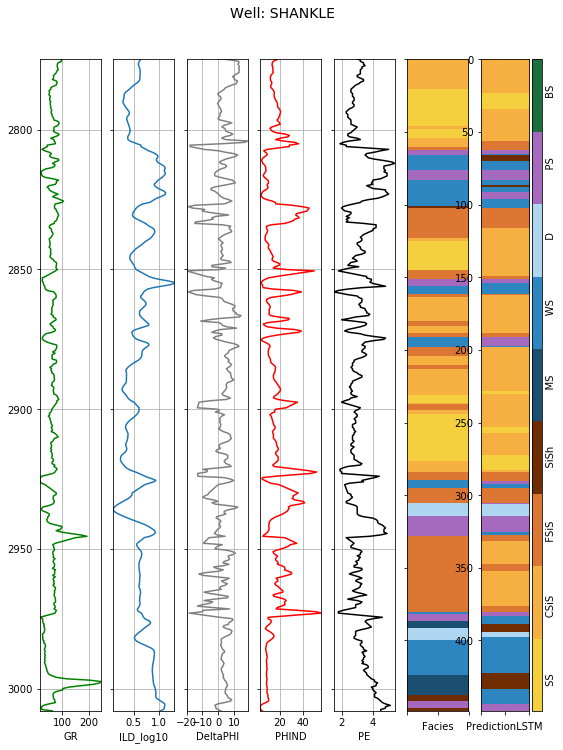

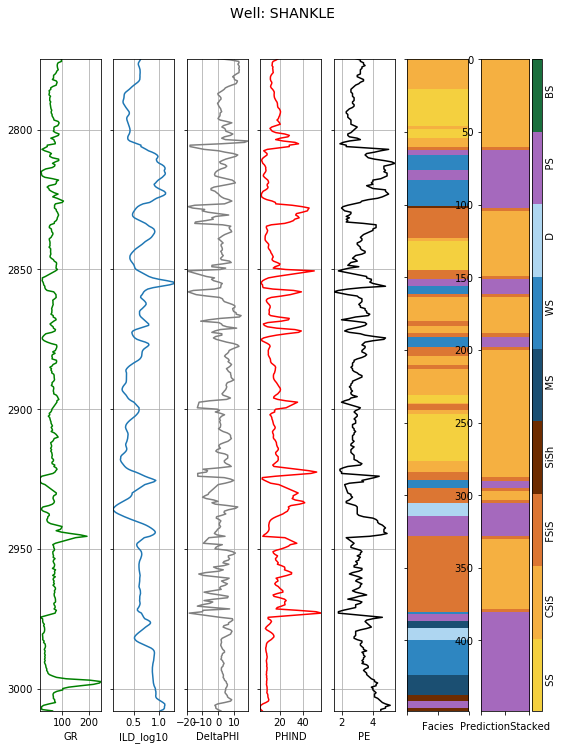

In [20]:
import matplotlib.pylab as plt
compare_facies_plot(all_wells['SHANKLE'], 
                    'PredictionSVC', facies_colors)
plt.show()
compare_facies_plot(all_wells['SHANKLE'], 
                    'PredictionLSTM', facies_colors)
plt.show()
compare_facies_plot(all_wells['SHANKLE'], 
                    'PredictionStacked', facies_colors)
plt.show()